## SETUP

In [164]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score,f1_score
sys.path.append("../Code/")
from utils import *
import xgboost
import seaborn as sns 
from strategies import ortb_bidding_strategy

## DATA LOAD

In [165]:
# data directory
DATA_DIR = os.path.join('..', 'Data')

In [166]:
# sparse might be important?

develop = False
load_blaze = True

train_X = pd.concat([pd.read_pickle(os.path.join(DATA_DIR, 'train_X_1')), 
                     pd.read_pickle(os.path.join(DATA_DIR, 'train_X_2'))])
train_y = pd.read_pickle(os.path.join(DATA_DIR, 'train_y'))
valid_X = pd.read_pickle(os.path.join(DATA_DIR, 'valid_X'))
valid_y = pd.read_pickle(os.path.join(DATA_DIR, 'valid_y'))

if load_blaze:
    train_X_b = pd.concat([pd.read_pickle(os.path.join(DATA_DIR, 'train_X_1_blaze')), 
                         pd.read_pickle(os.path.join(DATA_DIR, 'train_X_2_blaze'))])
    train_y_b = pd.read_pickle(os.path.join(DATA_DIR, 'train_y_blaze'))
    valid_X_b = pd.read_pickle(os.path.join(DATA_DIR, 'valid_X_blaze'))
    valid_y_b = pd.read_pickle(os.path.join(DATA_DIR, 'valid_y_blaze'))
    test_X_b = pd.read_pickle(os.path.join(DATA_DIR, 'test_X_blaze'))

if develop:
    train_X = train_X[0:10000]
    train_y = train_y[0:10000]
    valid_X = valid_X[0:1000]
    valid_y = valid_y[0:1000]

In [167]:
test_X = pd.read_pickle(os.path.join(DATA_DIR, 'test_X'))

In [168]:
train_X_encoded = csr_matrix(train_X) 
valid_X_encoded = csr_matrix(valid_X)
test_X_encoded = csr_matrix(test_X)

In [169]:
if load_blaze:
    train_X_encoded_b = csr_matrix(train_X_b) 
    valid_X_encoded_b = csr_matrix(valid_X_b)
    test_X_encoded_b = csr_matrix(test_X_b)
    print ("Train shape:", train_X_encoded_b.shape, "Valid shape:", valid_X_encoded_b.shape, "Test shape:", test_X_encoded_b.shape)

Train shape: (2430981, 824) Valid shape: (303925, 824) Test shape: (303375, 824)


In [170]:
print ("Train shape:", train_X_encoded.shape, "Valid shape:", valid_X_encoded.shape, "Test shape:", test_X_encoded.shape)

Train shape: (2430981, 823) Valid shape: (303925, 823) Test shape: (303375, 823)


## Load Model

In [234]:
#### IMPORT CTR PREDICTOR
import pickle
pkl_filename = "./lynray_xgb75.pkl"  
with open(pkl_filename, 'rb') as file:  
    xgb_75 = pickle.load(file)

In [235]:
#### IMPORT CTR PREDICTOR
import pickle
pkl_filename = "./lynray_xgbbest.pkl"  
with open(pkl_filename, 'rb') as file:  
    xgb_120 = pickle.load(file)

In [236]:
#### IMPORT CTR PREDICTOR
import pickle
pkl_filename = "./lynray_logbest.pkl"  
with open(pkl_filename, 'rb') as file:  
    log_model = pickle.load(file)

## Form CTR Predictions

In [174]:
valid_pred_log = log_model.predict_proba(valid_X_encoded_b)[:,1]

In [175]:
valid_pred_75 = xgb_75.predict(valid_X_encoded_b)

In [176]:
valid_pred_120 = xgb_120.predict(valid_X_encoded)

In [177]:
train_pred_log = log_model.predict_proba(train_X_encoded_b)[:,1]

In [178]:
train_pred_75 = xgb_75.predict(train_X_encoded_b)

In [179]:
train_pred_120 = xgb_120.predict(train_X_encoded)

## Evaluate ROC Scores

In [123]:
from sklearn.metrics import roc_auc_score
roc_auc_score(valid_y.click, valid_pred_log)

0.8445574985388424

In [87]:
roc_auc_score(valid_y.click, valid_pred_75)

0.8908080832381695

In [88]:
roc_auc_score(valid_y.click, valid_pred_120)

0.895512376229474

## AvgCTR

In [181]:
avgctr_75 = np.mean(train_pred_75)
avgctr_75

0.00073919527

In [188]:
avgctr_120 = np.mean(train_pred_120)
avgctr_120

0.00073955464

In [183]:
avgctr_log = np.mean(train_pred_log)
avgctr_log

0.27700866853329104

## Base Bid Optimization

In [45]:
def base_bid_optimization(min_val, max_val, n, preds, true):

    base_bid = np.linspace(min_val, max_val, n)
    clicks = np.zeros_like(base_bid)

    for i, bb in zip(range(n), base_bid):
        bids = bb*preds
        _, c, _, _, _, _, _ = new_performance(bids, true, verbose=False)
        clicks[i] = c
    plt.plot(base_bid, clicks)
    plt.show()

    # best result
    print("Best number of clicks:", np.max(clicks))
    print("Best base bid:", base_bid[np.argmax(clicks)])
    return base_bid[np.argmax(clicks)]

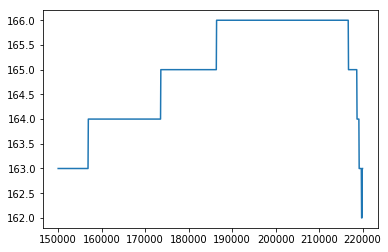

Best number of clicks: 166.0
Best base bid: 186436.43643643643


In [77]:
best_75 = base_bid_optimization(150000, 220000, 1000, valid_pred_75, valid_y)

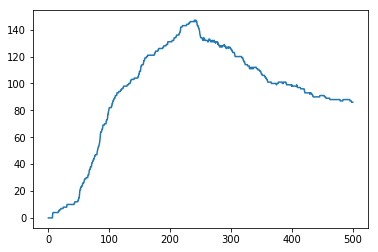

Best number of clicks: 147.0
Best base bid: 239.73973973973975


In [125]:
best_log = base_bid_optimization(0, 500, 1000, valid_pred_log, valid_y)

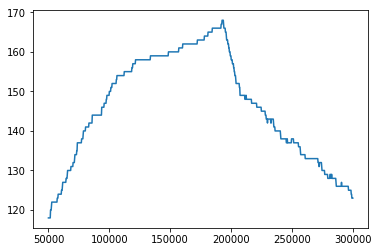

Best number of clicks: 168.0
Best base bid: 192642.64264264263


In [48]:
best_120 = base_bid_optimization(50000, 300000, 1000, valid_pred_120, valid_y)

In [126]:
bids_75 = best_75*valid_pred_75
_, c, _, _, _, _, _ = new_performance(bids_75, valid_y)

               CTR: (0.1547)%
        num_clicks: 166
             spend: 5511086 (88.18)%
              aCPM: 18.133045981738917
              aCPC: 33.19931325301205
num_in_budget_wins: 107291
 ads_within_budget: 303925


In [127]:
bids_log = best_log*valid_pred_log
_, c, _, _, _, _, _ = new_performance(bids_log, valid_y)

               CTR: (0.1181)%
        num_clicks: 147
             spend: 6234330 (99.75)%
              aCPM: 20.51272517890927
              aCPC: 42.41040816326531
num_in_budget_wins: 124507
 ads_within_budget: 303925


In [128]:
bids_120 = best_120*valid_pred_120
_, c, _, _, _, _, _ = new_performance(bids_120, valid_y)

               CTR: (0.1306)%
        num_clicks: 168
             spend: 6195407 (99.13)%
              aCPM: 20.384657399029365
              aCPC: 36.87742261904762
num_in_budget_wins: 128588
 ads_within_budget: 303925


### ORTB Strategy

In [129]:
def join_table(data, newData, rowLen, colLen):
    for col in newData.keys():
        data = data.join(pd.DataFrame({col: [newData[col][r, c] for r in range(rowLen) for c in range(colLen)]}).reset_index(drop=True))
    return data

In [130]:
def analysis_table(pred, y, params, t, budget=6250*1000):
    start = time.time()
    lmda_range = params[0]
    c_val_range = params[1]
    clicks = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    CTR = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    spend = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    CPM = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    eCPC = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    winrate_a = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    budget_lifetime = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    
    params = {'lamda': [lmda_range[l] for l in range(len(lmda_range)) for _ in range(len(c_val_range))],
              'c' : [c_val_range[c] for _ in range(len(lmda_range)) for c in range(len(c_val_range))]}
    vals = pd.DataFrame(params).reset_index(drop=True)

    for i, lm in zip(range(len(lmda_range)), lmda_range):
        for j, cv in zip(range(len(c_val_range)), c_val_range):
            bids = ortb_bidding_strategy(pred, cv, lm, t)
            CTR[i,j], clicks[i, j], s, CPM[i, j], eCPC[i, j], wins, imps  = new_performance(bids, y, budget=budget, verbose=False)
            spend[i,j] = 100*s/budget
            winrate_a[i,j] = wins*100/imps
            budget_lifetime[i,j]= imps*100/len(y)
    cols = {'CTR': CTR,
            'clicks': clicks,
            'spend%': spend,
            'aCPM': CPM,
            'eCPC': eCPC,
            'win%': winrate_a,
            'lifetime%': budget_lifetime}
    vals = join_table(vals, cols, len(lmda_range), len(c_val_range))

    print("time spent:- {0:.2f} seconds".format(time.time()-start))
    return vals, clicks

In [160]:
def plot_c_lambda(clicks, title):
    fig = plt.figure(figsize=plt.figaspect(0.25))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(title)
    ax.set_xlabel("C")
    ax.set_ylabel("Lambda")
    #plt.xticks
    plt.imshow(clicks, cmap='viridis', origin='lower')
    plt.MaxNLocator(100)
    plt.show()

In [225]:
lmda = np.linspace(5e-7, 3, 100)
c_val = np.linspace(0.1, 800, 100)

In [233]:
c_val[::20]

array([1.00000000e-03, 1.01010181e+03, 2.02020262e+03, 3.03030342e+03,
       4.04040423e+03])

In [133]:
a_75_1_t, c_75_1_t = analysis_table(valid_pred_75*100000, valid_y, [lmda, c_val], 1)

time spent:- 876.27 seconds


In [136]:
a_75_1_t.sort_values(by='clicks', ascending=False).head()

,c,lamda,CTR,clicks,spend%,aCPM,eCPC,win%,lifetime%
621,169.775758,0.181819,0.137481,167.0,97.390832,20.027727,36.448665,39.967426,100.0
624,194.015152,0.181819,0.135872,167.0,99.652720,20.492868,37.295180,40.440898,100.0
512,97.057576,0.151516,0.132257,167.0,99.817072,20.526666,37.356689,41.546105,100.0
618,145.536364,0.181819,0.139425,167.0,94.831952,19.501512,35.491000,39.410381,100.0
619,153.616162,0.181819,0.138702,167.0,95.752624,19.690841,35.835563,39.615695,100.0


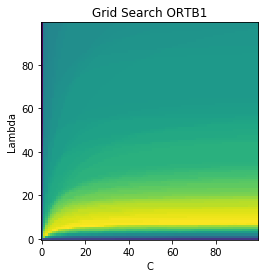

In [162]:
plot_c_lambda(c_75_1_t, "Grid Search ORTB1")

In [190]:
##### EXAMPLES OF ORTB BIDDING STRATEGY #####
print("ORTB test:-")
print("---------------------------------")
bids_ortb1 = ortb_bidding_strategy(valid_pred_75*100000, 194.015152, 0.181819, 1)
new_performance(bids_ortb1, valid_y)

ORTB test:-
---------------------------------
               CTR: (0.1359)%
        num_clicks: 167
             spend: 6228295 (99.65)%
              aCPM: 20.492868306325573
              aCPC: 37.295179640718565
num_in_budget_wins: 122910
 ads_within_budget: 303925


(0.13587177609633064,
 167,
 6228295,
 20.492868306325573,
 37.295179640718565,
 122910,
 303925)

In [230]:
lmda = np.linspace(5e-7, 2.5, 100)
c_val = np.linspace(0.001, 5000, 100)

In [194]:
ortb1 = pd.DataFrame({'bids':bids_ortb1, 'pCTR': valid_pred_75}).sort_values('pCTR')

In [196]:
ortb1.head()

,bids,pCTR
37881,0.304409,0.000001
161021,0.328993,0.000001
297012,0.333544,0.000001
217776,0.349191,0.000001
282328,0.367325,0.000001


In [157]:
a_75_2, c_75_2 = analysis_table(valid_pred_75*100000, valid_y, [lmda, c_val], 2)

time spent:- 992.22 seconds


In [158]:
a_75_2.sort_values(by='clicks', ascending=False).head()

,c,lamda,CTR,clicks,spend%,aCPM,eCPC,win%,lifetime%
7512,606.061485,1.893940,0.094912,154.0,99.999136,20.602950,40.584065,53.487368,99.811467
8628,1414.142131,2.171717,0.094499,153.0,99.999392,20.712179,40.849425,53.655473,99.285350
8836,1818.182455,2.222222,0.094684,153.0,99.999072,20.808586,40.849294,53.799850,98.825039
6006,303.031242,1.515152,0.095219,153.0,98.200096,20.194147,40.114418,52.868964,100.000000
6708,404.041323,1.691919,0.094894,153.0,98.805424,20.318628,40.361693,53.050259,100.000000


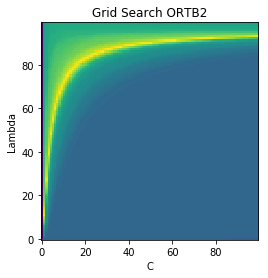

In [163]:
plot_c_lambda(c_75_2, "Grid Search ORTB2")

In [198]:
##### EXAMPLES OF ORTB BIDDING STRATEGY #####
print("ORTB test:-")
print("---------------------------------")
bids_ortb2 = ortb_bidding_strategy(valid_pred_75*100000, 606.154545, 1.893940, 2)
new_performance(bids_ortb2, valid_y)

ORTB test:-
---------------------------------
               CTR: (0.0943)%
        num_clicks: 153
             spend: 6249937 (100.00)%
              aCPM: 20.607131788057636
              aCPC: 40.849261437908496
num_in_budget_wins: 162237
 ads_within_budget: 303290


(0.09430647756060577,
 153,
 6249937,
 20.607131788057636,
 40.849261437908496,
 162237,
 303290)

In [199]:
ortb2 = pd.DataFrame({'bids':bids_ortb2, 'pCTR': valid_pred_75}).sort_values('pCTR')

### Model Evaluation

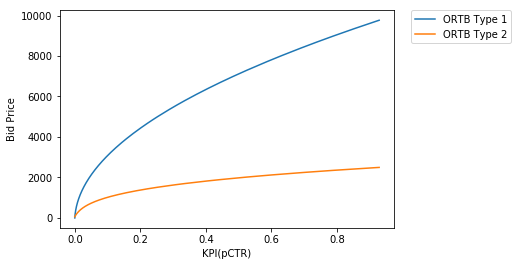

In [200]:
plt.plot(ortb1['pCTR'], ortb1['bids'], label="ORTB Type 1")
plt.plot(ortb2['pCTR'], ortb2['bids'], label="ORTB Type 2")
plt.xlabel("KPI(pCTR)")
plt.ylabel("Bid Price")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [96]:
def get_feature_importance(model, cols):
    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(cols, model.feature_importances_):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)
    return importances.sort_values(by="Gini-importance", ascending=False)

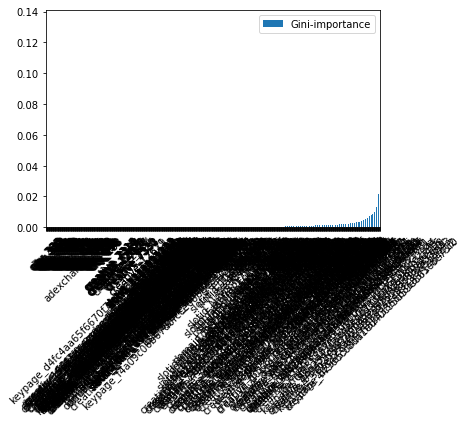

In [97]:
imps_100 = get_feature_importance(xgb_100, train_X.columns)

In [111]:
imps_sum = pd.DataFrame({'name': imps_100.index, 'importances': imps_100['Gini-importance']})
imps_sum['name'] = [a.split('_')[0] for a in imps_sum['name']]

In [112]:
imps_sum['name'] = ['usertag' if a.isdigit() else a for a in imps_sum['name'] ]

In [114]:
imps_sum.head()

,importances,name
hour,0.134392,hour
weekday,0.078009,weekday
slotprice,0.070626,slotprice
advertiser,0.036456,advertiser
10684,0.021430,usertag


In [117]:
sum_features = imps_sum.groupby(['name'])['importances'].sum().sort_values()

In [ ]:
imps_120 = get_feature_importance(xgb_120, train_X.columns)

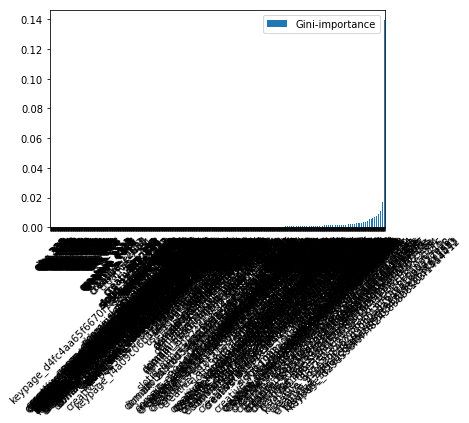

In [92]:
imps_75 = get_feature_importance(xgb_75, train_X.columns)

In [ ]:
no_imps = pd.DataFrame({'name': imps[imps['Gini-importance'] == 0].index, 'importances': imps[imps['Gini-importance'] == 0]['Gini-importance']})
no_imps['name'] = [a.split('_')[0] for a in no_imps['name']]
no_imps['name'].value_counts()
## Plot that

### Save Model

In [ ]:
best_ortb1_c = 
best_ortb1_l = 
best_ortb2_c = 
best_ortb2_l = 

In [19]:
import pickle as pkl
pkl_filename = '../lynray_xgb75.pkl'
with open(pkl_filename, 'wb') as file:  
    pkl.dump(xgb_model_75, file)

In [17]:
### Save Training Bids
train_bids = pd.DataFrame({"bidpriceORTB1": ortb_bidding_strategy(xgb_75.predict(train_X_encoded)*100000, best_ortb1_c, best_ortb1_l, 1),
                            "bidpriceORTB2": ortb_bidding_strategy(xgb_75.predict(train_X_encoded)*100000,  best_ortb2_c, best_ortb2_l, 2)
                            })

train_bids.to_csv('../train_bids_75.csv')

In [18]:
### Save Validation Bids
valid_bids = pd.DataFrame({"bidpriceORTB1": ortb_bidding_strategy(xgb_75.predict(valid_X_encoded)*100000, best_ortb1_c, best_ortb1_l, 1),
                            "bidpriceORTB2": ortb_bidding_strategy(xgb_75.predict(valid_X_encoded)*100000,  best_ortb2_c, best_ortb2_l, 2)
                            })

valid_bids.to_csv('../valid_bids_75.csv')

In [20]:
### Save Test Bids
test_bids = pd.DataFrame({"bidpriceORTB1": ortb_bidding_strategy(xgb_75.predict(test_X_encoded)*100000, best_ortb1_c, best_ortb1_l, 1),
                            "bidpriceORTB2": ortb_bidding_strategy(xgb_75.predict(test_X_encoded)*100000,  best_ortb2_c, best_ortb2_l, 2)
                             })

test_bids.to_csv('../test_bids.csv')

In [ ]:
### Prepare Submission

In [20]:
submission = pd.read_csv('../Data/Group_xx.csv')

In [21]:
submission.head()

,bidid,bidprice
0,366c563de7d90feb9d4dab53e795a93fb3157387,0.0
1,29167d4caa719788b5a342dbaa25151d53121f80,0.0
2,ff8bc3f4d44a3ea60c5f3a3a8fbe7cd98fb2966e,0.0
3,844c2da00d45315f20b748ec131c26ee99a7cbc7,0.0
4,c6017f0ad0c44d7d0c9b62583ea863f28941c0ca,0.0


In [23]:
test_predictions = test_bids['bidpriceORTB2']

In [24]:
submission.bidprice = test_predictions

In [25]:
submission.to_csv('../Group_01_xgbbb_75.csv')